In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [2]:
# learning parameters
batch_size = 64
epochs = 100
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [4]:
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [7]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

In [8]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0001)
optim_d = optim.Adam(discriminator.parameters(), lr=0.00005)

In [9]:
# loss function
criterion = nn.BCELoss()

In [10]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [11]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [12]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [13]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [14]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [15]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [16]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [17]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [18]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"output/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

938it [01:31, 10.27it/s]


Epoch 0 of 100
Generator loss: 1.07288277, Discriminator loss: 1.16207004


938it [01:31, 10.28it/s]


Epoch 1 of 100
Generator loss: 1.20202470, Discriminator loss: 1.11498857


938it [01:30, 10.42it/s]                         


Epoch 2 of 100
Generator loss: 2.71468663, Discriminator loss: 0.52315277


938it [01:28, 10.55it/s]                         


Epoch 3 of 100
Generator loss: 3.96194696, Discriminator loss: 0.28443679


938it [01:27, 10.70it/s]


Epoch 4 of 100
Generator loss: 3.99285054, Discriminator loss: 0.30455294


938it [01:27, 10.68it/s]


Epoch 5 of 100
Generator loss: 3.60222554, Discriminator loss: 0.39631149


938it [01:28, 10.54it/s]                         


Epoch 6 of 100
Generator loss: 3.39697242, Discriminator loss: 0.41003761


938it [01:27, 10.75it/s]


Epoch 7 of 100
Generator loss: 2.93701100, Discriminator loss: 0.51289415


938it [01:27, 10.78it/s]                         


Epoch 8 of 100
Generator loss: 2.71641612, Discriminator loss: 0.54215550


938it [01:27, 10.72it/s]


Epoch 9 of 100
Generator loss: 2.52523923, Discriminator loss: 0.57041019


938it [01:27, 10.77it/s]


Epoch 10 of 100
Generator loss: 2.46176815, Discriminator loss: 0.58814639


938it [01:27, 10.77it/s]


Epoch 11 of 100
Generator loss: 2.35735941, Discriminator loss: 0.64232343


938it [01:26, 10.83it/s]


Epoch 12 of 100
Generator loss: 2.26200509, Discriminator loss: 0.65380186


938it [01:26, 10.78it/s]


Epoch 13 of 100
Generator loss: 2.06863117, Discriminator loss: 0.71451527


938it [01:27, 10.74it/s]


Epoch 14 of 100
Generator loss: 2.06581116, Discriminator loss: 0.71139449


938it [01:26, 10.79it/s]                         


Epoch 15 of 100
Generator loss: 1.94953537, Discriminator loss: 0.74615461


938it [01:27, 10.76it/s]                         


Epoch 16 of 100
Generator loss: 1.82754850, Discriminator loss: 0.78739202


938it [01:29, 10.52it/s]


Epoch 17 of 100
Generator loss: 1.76446378, Discriminator loss: 0.81639600


938it [01:29, 10.48it/s]                         


Epoch 18 of 100
Generator loss: 1.66514277, Discriminator loss: 0.85204816


938it [01:28, 10.63it/s]                         


Epoch 19 of 100
Generator loss: 1.63561165, Discriminator loss: 0.86528790


938it [01:28, 10.60it/s]


Epoch 20 of 100
Generator loss: 1.51515293, Discriminator loss: 0.91338158


938it [01:29, 10.48it/s]


Epoch 21 of 100
Generator loss: 1.48648620, Discriminator loss: 0.93028849


938it [01:28, 10.58it/s]


Epoch 22 of 100
Generator loss: 1.40733647, Discriminator loss: 0.97031742


938it [01:29, 10.51it/s]


Epoch 23 of 100
Generator loss: 1.43019116, Discriminator loss: 0.96650523


938it [01:30, 10.37it/s]


Epoch 24 of 100
Generator loss: 1.38940465, Discriminator loss: 0.98249817


938it [01:31, 10.24it/s]                         


Epoch 25 of 100
Generator loss: 1.35329497, Discriminator loss: 1.00603342


938it [01:31, 10.29it/s]                         


Epoch 26 of 100
Generator loss: 1.27962160, Discriminator loss: 1.04036450


938it [01:32, 10.09it/s]


Epoch 27 of 100
Generator loss: 1.30811965, Discriminator loss: 1.02760625


938it [01:32, 10.13it/s]


Epoch 28 of 100
Generator loss: 1.25532198, Discriminator loss: 1.06006229


938it [01:31, 10.24it/s]


Epoch 29 of 100
Generator loss: 1.22177529, Discriminator loss: 1.06340206


938it [01:29, 10.52it/s]                         


Epoch 30 of 100
Generator loss: 1.22382474, Discriminator loss: 1.07723653


938it [01:29, 10.53it/s]


Epoch 31 of 100
Generator loss: 1.17633128, Discriminator loss: 1.09629405


938it [01:27, 10.68it/s]                         


Epoch 32 of 100
Generator loss: 1.16337359, Discriminator loss: 1.10268641


938it [01:29, 10.46it/s]


Epoch 33 of 100
Generator loss: 1.14900148, Discriminator loss: 1.10871816


938it [01:31, 10.21it/s]                         


Epoch 34 of 100
Generator loss: 1.12787414, Discriminator loss: 1.12841046


938it [01:31, 10.25it/s]                         


Epoch 35 of 100
Generator loss: 1.09981763, Discriminator loss: 1.14545810


938it [01:29, 10.49it/s]                         


Epoch 36 of 100
Generator loss: 1.09987855, Discriminator loss: 1.14329076


938it [01:29, 10.42it/s]                         


Epoch 37 of 100
Generator loss: 1.08887887, Discriminator loss: 1.14711952


938it [01:30, 10.38it/s]                         


Epoch 38 of 100
Generator loss: 1.07999539, Discriminator loss: 1.15369487


938it [01:31, 10.26it/s]


Epoch 39 of 100
Generator loss: 1.06863725, Discriminator loss: 1.16281068


938it [01:31, 10.20it/s]


Epoch 40 of 100
Generator loss: 1.04942477, Discriminator loss: 1.17220747


938it [01:33, 10.05it/s]


Epoch 41 of 100
Generator loss: 1.05278409, Discriminator loss: 1.16965926


938it [01:29, 10.53it/s]                         


Epoch 42 of 100
Generator loss: 1.05008471, Discriminator loss: 1.17506433


938it [01:30, 10.41it/s]


Epoch 43 of 100
Generator loss: 1.03944981, Discriminator loss: 1.17430961


938it [01:30, 10.37it/s]


Epoch 44 of 100
Generator loss: 1.03217423, Discriminator loss: 1.18260252


938it [01:33,  9.98it/s]                         


Epoch 45 of 100
Generator loss: 1.02700567, Discriminator loss: 1.18646538


938it [01:33, 10.08it/s]


Epoch 46 of 100
Generator loss: 1.01625204, Discriminator loss: 1.18994570


938it [01:29, 10.50it/s]                         


Epoch 47 of 100
Generator loss: 1.02275968, Discriminator loss: 1.19370604


938it [01:29, 10.50it/s]                         


Epoch 48 of 100
Generator loss: 1.01407266, Discriminator loss: 1.19489110


938it [01:29, 10.47it/s]                         


Epoch 49 of 100
Generator loss: 1.00497413, Discriminator loss: 1.19823563


938it [01:32, 10.16it/s]                         


Epoch 50 of 100
Generator loss: 0.99157667, Discriminator loss: 1.20301795


938it [01:31, 10.24it/s]                         


Epoch 51 of 100
Generator loss: 1.00372064, Discriminator loss: 1.20646954


938it [01:29, 10.46it/s]


Epoch 52 of 100
Generator loss: 1.00687027, Discriminator loss: 1.20183730


938it [01:27, 10.70it/s]                         


Epoch 53 of 100
Generator loss: 0.96970063, Discriminator loss: 1.21627927


938it [01:27, 10.69it/s]                         


Epoch 54 of 100
Generator loss: 0.98887068, Discriminator loss: 1.20927787


938it [01:26, 10.81it/s]


Epoch 55 of 100
Generator loss: 0.98159599, Discriminator loss: 1.21860433


938it [01:27, 10.69it/s]


Epoch 56 of 100
Generator loss: 0.96906376, Discriminator loss: 1.21558774


938it [01:28, 10.65it/s]                         


Epoch 57 of 100
Generator loss: 0.96868831, Discriminator loss: 1.22070158


938it [01:27, 10.66it/s]


Epoch 58 of 100
Generator loss: 0.97495300, Discriminator loss: 1.22539139


938it [01:28, 10.55it/s]                         


Epoch 59 of 100
Generator loss: 0.95398301, Discriminator loss: 1.22792029


938it [01:30, 10.35it/s]


Epoch 60 of 100
Generator loss: 0.95872915, Discriminator loss: 1.22916329


938it [01:29, 10.45it/s]                         


Epoch 61 of 100
Generator loss: 0.94025624, Discriminator loss: 1.23824883


938it [01:32, 10.16it/s]                         


Epoch 62 of 100
Generator loss: 0.94226211, Discriminator loss: 1.23717678


938it [01:29, 10.51it/s]


Epoch 63 of 100
Generator loss: 0.94803464, Discriminator loss: 1.23818731


938it [01:27, 10.67it/s]                         


Epoch 64 of 100
Generator loss: 0.94150758, Discriminator loss: 1.23867631


938it [01:27, 10.71it/s]                         


Epoch 65 of 100
Generator loss: 0.93365461, Discriminator loss: 1.23998821


938it [01:27, 10.72it/s]


Epoch 66 of 100
Generator loss: 0.93429899, Discriminator loss: 1.24778473


938it [01:27, 10.75it/s]                         


Epoch 67 of 100
Generator loss: 0.92314899, Discriminator loss: 1.24842834


938it [01:27, 10.70it/s]                         


Epoch 68 of 100
Generator loss: 0.93859035, Discriminator loss: 1.24250853


938it [01:27, 10.77it/s]


Epoch 69 of 100
Generator loss: 0.93106103, Discriminator loss: 1.24531472


938it [01:30, 10.37it/s]                         


Epoch 70 of 100
Generator loss: 0.92859882, Discriminator loss: 1.24959171


938it [01:30, 10.37it/s]


Epoch 71 of 100
Generator loss: 0.93143576, Discriminator loss: 1.24715900


938it [01:27, 10.75it/s]


Epoch 72 of 100
Generator loss: 0.92239821, Discriminator loss: 1.24966049


938it [01:27, 10.68it/s]


Epoch 73 of 100
Generator loss: 0.91934735, Discriminator loss: 1.24662054


938it [01:27, 10.74it/s]                         


Epoch 74 of 100
Generator loss: 0.92158240, Discriminator loss: 1.25252271


938it [01:27, 10.73it/s]


Epoch 75 of 100
Generator loss: 0.90425777, Discriminator loss: 1.25669110


938it [01:27, 10.71it/s]                         


Epoch 76 of 100
Generator loss: 0.91866034, Discriminator loss: 1.25295532


938it [01:28, 10.66it/s]


Epoch 77 of 100
Generator loss: 0.91108400, Discriminator loss: 1.26108611


938it [01:27, 10.75it/s]


Epoch 78 of 100
Generator loss: 0.89777958, Discriminator loss: 1.26216149


938it [01:27, 10.69it/s]                         


Epoch 79 of 100
Generator loss: 0.90768540, Discriminator loss: 1.25992918


938it [01:27, 10.74it/s]


Epoch 80 of 100
Generator loss: 0.89788717, Discriminator loss: 1.26396310


938it [01:27, 10.75it/s]                         


Epoch 81 of 100
Generator loss: 0.89292157, Discriminator loss: 1.26647830


938it [01:27, 10.66it/s]


Epoch 82 of 100
Generator loss: 0.90488893, Discriminator loss: 1.26106107


938it [01:28, 10.60it/s]                         


Epoch 83 of 100
Generator loss: 0.91225928, Discriminator loss: 1.25875854


938it [01:27, 10.68it/s]                         


Epoch 84 of 100
Generator loss: 0.89476770, Discriminator loss: 1.26290476


938it [01:27, 10.73it/s]                         


Epoch 85 of 100
Generator loss: 0.89699298, Discriminator loss: 1.26739323


938it [01:28, 10.62it/s]                         


Epoch 86 of 100
Generator loss: 0.88786250, Discriminator loss: 1.26631272


938it [01:27, 10.73it/s]


Epoch 87 of 100
Generator loss: 0.87726438, Discriminator loss: 1.27516508


938it [01:27, 10.71it/s]                         


Epoch 88 of 100
Generator loss: 0.89225817, Discriminator loss: 1.26750207


938it [01:27, 10.70it/s]


Epoch 89 of 100
Generator loss: 0.89020807, Discriminator loss: 1.27225518


938it [01:27, 10.66it/s]


Epoch 90 of 100
Generator loss: 0.88910812, Discriminator loss: 1.27386701


938it [01:27, 10.69it/s]                         


Epoch 91 of 100
Generator loss: 0.87597054, Discriminator loss: 1.27321684


938it [01:27, 10.70it/s]                         


Epoch 92 of 100
Generator loss: 0.89697462, Discriminator loss: 1.26947451


938it [01:27, 10.66it/s]                         


Epoch 93 of 100
Generator loss: 0.88486993, Discriminator loss: 1.27580142


938it [01:28, 10.65it/s]


Epoch 94 of 100
Generator loss: 0.88096160, Discriminator loss: 1.27356911


938it [01:27, 10.71it/s]


Epoch 95 of 100
Generator loss: 0.88397491, Discriminator loss: 1.27667868


938it [01:27, 10.68it/s]


Epoch 96 of 100
Generator loss: 0.88427925, Discriminator loss: 1.27178442


938it [01:26, 10.80it/s]


Epoch 97 of 100
Generator loss: 0.88019389, Discriminator loss: 1.27265906


938it [01:27, 10.70it/s]                         


Epoch 98 of 100
Generator loss: 0.88048100, Discriminator loss: 1.27340674


938it [01:27, 10.68it/s]

Epoch 99 of 100
Generator loss: 0.87884200, Discriminator loss: 1.27919626


In [20]:
torch.save(generator.state_dict(), 'output/generator.pth')

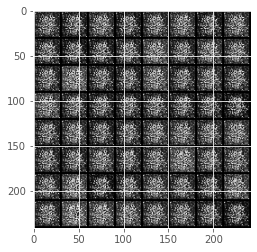

In [107]:
plt.imshow( imgs[0] )

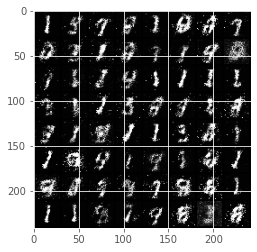

In [108]:
plt.imshow( imgs[10] )

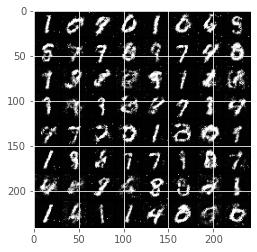

In [109]:
plt.imshow( imgs[25] )

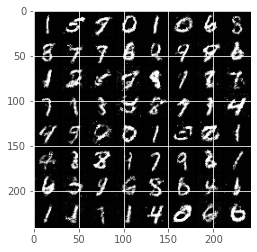

In [110]:
plt.imshow( imgs[55] )

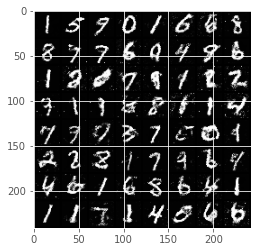

In [111]:
plt.imshow( imgs[99] )

In [99]:
torch.FloatTensor(losses_d)

tensor([1.1621, 1.1150, 0.5232, 0.2844, 0.3046, 0.3963, 0.4100, 0.5129, 0.5422,
        0.5704, 0.5881, 0.6423, 0.6538, 0.7145, 0.7114, 0.7462, 0.7874, 0.8164,
        0.8520, 0.8653, 0.9134, 0.9303, 0.9703, 0.9665, 0.9825, 1.0060, 1.0404,
        1.0276, 1.0601, 1.0634, 1.0772, 1.0963, 1.1027, 1.1087, 1.1284, 1.1455,
        1.1433, 1.1471, 1.1537, 1.1628, 1.1722, 1.1697, 1.1751, 1.1743, 1.1826,
        1.1865, 1.1899, 1.1937, 1.1949, 1.1982, 1.2030, 1.2065, 1.2018, 1.2163,
        1.2093, 1.2186, 1.2156, 1.2207, 1.2254, 1.2279, 1.2292, 1.2382, 1.2372,
        1.2382, 1.2387, 1.2400, 1.2478, 1.2484, 1.2425, 1.2453, 1.2496, 1.2472,
        1.2497, 1.2466, 1.2525, 1.2567, 1.2530, 1.2611, 1.2622, 1.2599, 1.2640,
        1.2665, 1.2611, 1.2588, 1.2629, 1.2674, 1.2663, 1.2752, 1.2675, 1.2723,
        1.2739, 1.2732, 1.2695, 1.2758, 1.2736, 1.2767, 1.2718, 1.2727, 1.2734,
        1.2792])

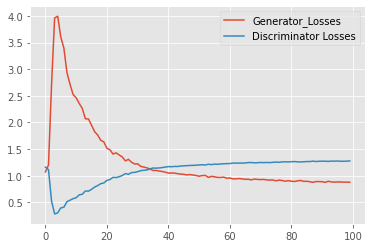

In [100]:

plt.plot(torch.FloatTensor(losses_g), label='Generator_Losses')
plt.plot(torch.FloatTensor(losses_d), label='Discriminator Losses')
plt.legend()


---



---



---



In [112]:
# loss function
criterion = nn.MSELoss()

In [113]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [114]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [115]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [116]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [117]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [118]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [119]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [120]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [121]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"output/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

938it [01:29, 10.48it/s]


Epoch 0 of 100
Generator loss: 0.32203743, Discriminator loss: 0.44680107


938it [01:29, 10.44it/s]


Epoch 1 of 100
Generator loss: 0.32412118, Discriminator loss: 0.44859165


 41%|████▏     | 388/937 [00:37<00:52, 10.47it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(generator.state_dict(), 'output/generator.pth')

In [ ]:
plt.imshow( imgs[0] )

In [ ]:
plt.imshow( imgs[10] )

In [ ]:
plt.imshow( imgs[25] )

In [ ]:
plt.imshow( imgs[55] )

In [ ]:
plt.imshow( imgs[99] )

In [ ]:
torch.FloatTensor(losses_d)

In [ ]:

plt.plot(torch.FloatTensor(losses_g), label='Generator_Losses')
plt.plot(torch.FloatTensor(losses_d), label='Discriminator Losses')
plt.legend()



---



---



---



---




---



---



---



In [122]:
# loss function
criterion = nn.CTCLoss()

In [123]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [124]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [125]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [126]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [127]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [128]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [129]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [130]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [131]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"output/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

  0%|          | 0/937 [00:00<?, ?it/s]


TypeError: ignored

In [ ]:
torch.save(generator.state_dict(), 'output/generator.pth')

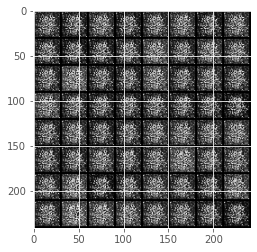

In [132]:
plt.imshow( imgs[0] )

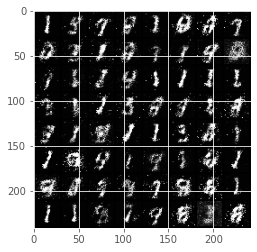

In [133]:
plt.imshow( imgs[10] )

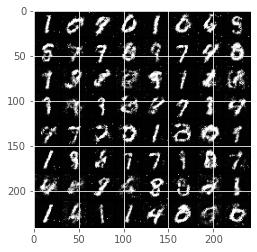

In [134]:
plt.imshow( imgs[25] )

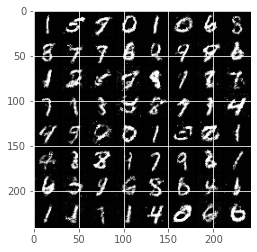

In [135]:
plt.imshow( imgs[55] )

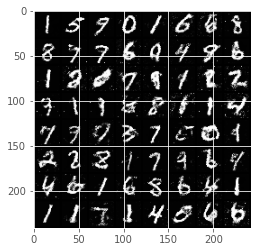

In [136]:
plt.imshow( imgs[99] )

In [137]:
torch.FloatTensor(losses_d)

tensor([])

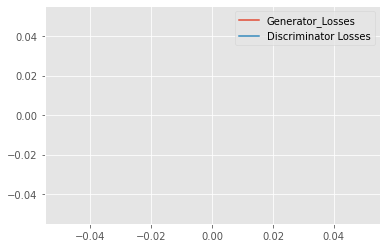

In [138]:

plt.plot(torch.FloatTensor(losses_g), label='Generator_Losses')
plt.plot(torch.FloatTensor(losses_d), label='Discriminator Losses')
plt.legend()